In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [3]:
import matplotlib.pyplot as plt
import numpy as np


In [4]:
figname = '../paper/fig_intro'

# display images

#### MNIST dataset read out

In [5]:
from retina import get_data_loader

In [6]:
loader = get_data_loader(batch_size=100, train=False)

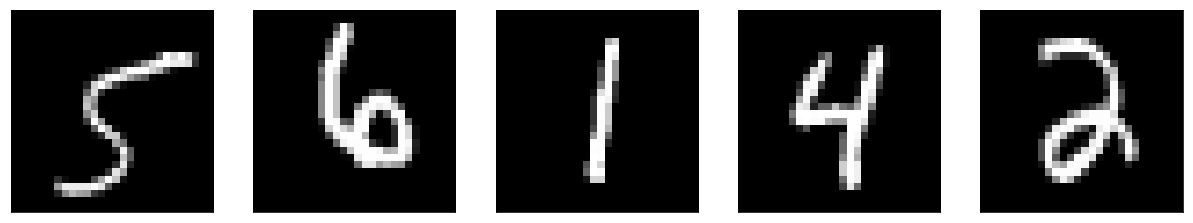

In [7]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for ax in axs:
    data, label = next(iter(loader))
    ax.imshow(data[0, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])


In [8]:
N_pic = 128

minibatch_size = 100  # quantity of examples that'll be processed
lr = 1e-4 #1e-3  #0.05

OFFSET_STD = 40 #
OFFSET_MAX = 30 #
NOISE = 1. #0 #
CONTRAST = 0.7 #1 #
sf_0 = 0.2
B_sf = 0.3

In [9]:
from retina import minmax, place_object

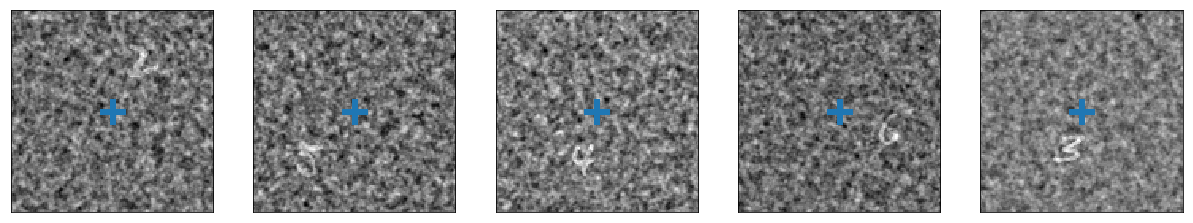

In [10]:
N_plot = 5
fig, axs = plt.subplots(1, N_plot, figsize = (21, 8))
for ax in axs:
    data, label = next(iter(loader))
    offset_std = OFFSET_STD
    offset_max = OFFSET_MAX
    i_offset = minmax(np.random.randn() * offset_std, offset_max)
    j_offset = minmax(np.random.randn() * offset_std, offset_max)
    data_fullfield = place_object(data[0, 0, :, :].numpy(), i_offset, j_offset,  N_pic=N_pic,
                                    CONTRAST=CONTRAST, NOISE=NOISE,
                                    sf_0=sf_0, B_sf=B_sf)
    ax.imshow(data_fullfield, cmap=plt.gray())
    ax.plot([N_pic//2], [N_pic//2], '+', ms=26, markeredgewidth=6)
    ax.set_xticks([])
    ax.set_yticks([])

i_offset -30
j_offset 30


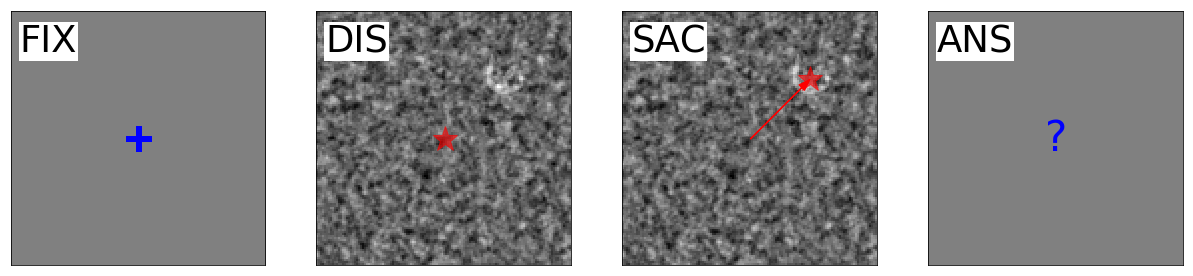

In [12]:
data, label = next(iter(loader))
offset_std = OFFSET_STD
offset_max = OFFSET_MAX
i_offset = minmax(np.random.randn() * offset_std, offset_max)
j_offset = minmax(np.random.randn() * offset_std, offset_max)
data_fullfield = place_object(data[0, 0, :, :].numpy(), i_offset, j_offset,  N_pic=N_pic,
                                CONTRAST=CONTRAST, NOISE=NOISE,
                                sf_0=sf_0, B_sf=B_sf)
print('i_offset', i_offset)
print('j_offset', j_offset)

N_plot = 4

texts = ['FIX', 'DIS', 'SAC', 'ANS']
fig, axs = plt.subplots(1, N_plot, figsize = (21, 13))
for ax, text in zip(axs, texts):
    ax.imshow(np.zeros_like(data_fullfield), cmap=plt.gray(), vmin=-1, vmax=1)
    if text=='FIX': 
        ax.plot([N_pic//2], [N_pic//2], '+', color='b', ms=26, markeredgewidth=6)
    elif text in ['DIS', 'SAC']: 
        ax.imshow(data_fullfield, cmap=plt.gray())
        opts = dict(ms=26, markeredgewidth=1, alpha=.6)
        if text == 'DIS':
            ax.plot([N_pic//2], [N_pic//2], '*r', **opts)
        else:
            ax.plot([N_pic//2+j_offset], [N_pic//2+i_offset], '*r', **opts)
            ax.arrow(N_pic//2, N_pic//2, j_offset, i_offset, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
    elif text=='ANS':         
        ax.text(N_pic//2, N_pic//2, '?', color='b', fontsize=42,
          ha='center', va='center')

    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(4, 15, text, fontsize=37,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 


fig.savefig(figname + '.pdf')

# foveation

In [ ]:
N_theta = 6
N_azimuth = 16
N_eccentricity = 10
N_phase = 2
N_X = 128
N_Y = 128
rho = 1.41
verbose = 1


In [ ]:
from retina import vectorization

retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)

In [ ]:
from retina import  retina, retina_inverse
retina_inverse_transform = retina_inverse(retina_transform)

In [ ]:
data_retina, tensor_retina   = retina(data_fullfield, retina_transform)


#### Full encoding

In [ ]:
retina_transform = vectorization(N_theta, N_azimuth, N_eccentricity, N_phase, N_X, N_Y, rho)
print(retina_transform.shape)

In [ ]:
retina_vector = retina_transform.reshape((N_theta*N_azimuth*N_eccentricity*N_phase, N_X*N_Y))
print(retina_vector.shape)

In [ ]:
retina_inverse = np.linalg.pinv(retina_vector)
print(retina_inverse.shape)

#### Orientation invariant power encoding (colliculus??)

In [ ]:
colliculus = (retina_transform**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

In [ ]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

In [ ]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

In [ ]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

# summary

In [ ]:
import tikzmagic

In [ ]:
%load_ext tikzmagic

In [ ]:
%%tikz 
\draw (0,0) rectangle (1,1);

In [ ]:
%load_ext version_information
%version_information numpy, tikzmagic

# protocol_recording

In [ ]:
!rm  -f {figname}*

In [ ]:
%%tikz  -l arrows.meta --scale 15 -f pdf -S {figname}.pdf

\def\Titre{6}
\def\sousTitre{4}
\def\text{4}

\def\a{0.3} % ecart horizontal
\def\b{0.1} % ecart vertical

% \draw (.85, 4.15) rectangle (1.25, 4.35);

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (0, -0.5) rectangle (1, 0.5);
\filldraw [white] (0.5, 0) circle (.02);
\draw [white] (0.5, 0.1) node[above, scale=\Titre, font =\sffamily] {FIXATION};
\draw [white] (0.5, -0.1) node[below, scale=\sousTitre, font =\sffamily] {(ramdom)};

\draw [line width=1mm, -{Stealth[length=2mm]}, thick] (1.03,0) -- (1.27,0);

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (1+\a,-0.5) rectangle (2+\a,0.5);
\draw [white] (1.5+\a, 0) node[above, scale=\Titre, font =\sffamily] {GAP};
%\draw [white] (1.5+\a, 0) node[below, scale=\sousTitre, font =\sffamily] {(300ms)};

\draw [line width=1mm, -{Stealth[length=2mm]}, thick] (2.03+\a,0) -- (2.27+\a,0.5+\b);
\draw [black] (2.26+\a, 0.7) node[above, left, scale=\text, font =\sffamily] {Display;

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (2+\a+\a,0+\b) rectangle (3+\a+\a,1+\b);
\filldraw [line width=1mm, color=white, fill=black!50!white] (2.5+\a+\a,0.5+\b) circle(.02);
\draw [line width=1mm, -{Stealth[length=2mm]}, thick, white] (2.55+\a+\a,0.5+\b) -- (2.55+\a+\a+\a,0.5+\b);

\draw [line width=1mm, -{Stealth[length=2mm]}, thick] (2.03+\a,0) -- (2.27+\a,-0.5-\b);
\draw [black] (2.26+\a,-0.7) node[below, left, scale=\text, font =\sffamily] {Response};

\draw [line width=0.1mm, color=black!75!white, fill=black!50!white] (2+\a+\a,-1-\b) rectangle (3+\a+\a,0-\b);
\filldraw [line width=1mm, color=white, fill=black!50!white] (2.5+\a+\a,-0.5-\b) circle(.02);
\draw [line width=1mm, -{Stealth[length=2mm]}, thick, white] (2.45+\a+\a,-0.5-\b) -- (2.45+\a,-0.5-\b);
                                                                              
% \draw [anchor=north west] (.5\linewidth, .382\linewidth) node {\includegraphics[width=.5\linewidth]{/tmp/panel_B.pdf}};
\begin{scope}[font=\bf\sffamily\large]
\draw [anchor=west,fill=white] (.0\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{A}$};
\draw [anchor=west,fill=white] (.53\linewidth, .382\linewidth) node [above right=-3mm] {$\mathsf{B}$};
\end{scope}
                                                                              

In [ ]:
!convert -density 600  -flatten  -compress lzw -units pixelsperinch  -depth 8 {figname}.pdf {figname}.png
!convert  -density 300  -units pixelsperinch {figname}.pdf  {figname}.jpg
!convert -density 600  -flatten  -compress lzw -units pixelsperinch  -depth 8 {figname}.pdf {figname}.tiff
!echo "width=" ; convert figures/{figname}.tiff -format "%[fx:w]" info:
!echo ", \nheight=" ; convert figures/{figname}.tiff -format "%[fx:h]" info:
!echo ", \nunit=" ; convert figures/{figname}.tiff -format "%U" info:   

In [ ]:
!ls  -l {figname}*

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))